In [ ]:
from google.colab import drive
import os

# Mount the drive
drive.mount('/content/drive')



In [59]:
import os
import glob
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import copy

# --- CONFIGURATION ---
CONFIG = {
    'SEED': 42,
    'NUM_PATIENTS': 500,
    'IMG_SIZE': 128,
    'BATCH_SIZE': 32,
    'LR': 1e-4,
    'EPOCHS': 15,
    'PATIENCE': 5,
    'MC_DROPOUT_PASSES': 20,
    'DATA_ROOT': '/content/drive/MyDrive/BraTs Dataset',
    'SAVE_PATH': '/content/processed_data'
}

# --- REPRODUCIBILITY ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['SEED'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Configuration loaded. Using device: {device}")

Configuration loaded. Using device: cuda


In [ ]:
if not os.path.exists(CONFIG['SAVE_PATH']):
    os.makedirs(CONFIG['SAVE_PATH'])

def normalize(volume):
    """Min-max normalization."""
    min_val, max_val = volume.min(), volume.max()
    if max_val - min_val == 0: return volume
    return (volume - min_val) / (max_val - min_val)

def preprocess_and_save():
    """Extracts tumor slices and saves as .npy files."""
    # Get patient folders
    patient_folders = sorted([
        p for p in os.listdir(CONFIG['DATA_ROOT'])
        if os.path.isdir(os.path.join(CONFIG['DATA_ROOT'], p)) and 'BraTS' in p
    ])

    # Limit dataset size
    patient_folders = patient_folders[:CONFIG['NUM_PATIENTS']]

    print(f"Preprocessing {len(patient_folders)} patients...")
    saved_count = 0

    for patient_id in tqdm(patient_folders):
        patient_path = os.path.join(CONFIG['DATA_ROOT'], patient_id)

    
        flair_path = os.path.join(patient_path, f"{patient_id}_flair.nii.gz")
        seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii.gz")

        if not os.path.exists(flair_path) or not os.path.exists(seg_path):
            continue

        try:
            flair_vol = nib.load(flair_path).get_fdata()
            seg_vol = nib.load(seg_path).get_fdata()

            # Flatten labels to binary (Tumor=1, Background=0)
            seg_vol[seg_vol > 0] = 1

            # Find slice with most tumor
            tumor_counts = np.sum(seg_vol, axis=(0, 1))
            if np.max(tumor_counts) == 0: continue # Skip empty patients
            max_tumor_idx = np.argmax(tumor_counts)

            # Extract & Normalize
            img_slice = normalize(flair_vol[:, :, max_tumor_idx])
            mask_slice = seg_vol[:, :, max_tumor_idx]

            # Save
            np.save(os.path.join(CONFIG['SAVE_PATH'], f"{patient_id}.npy"), {
                'image': img_slice.astype(np.float32),
                'mask': mask_slice.astype(np.float32)
            })
            saved_count += 1

        except Exception as e:
            print(f"Error: {patient_id} - {e}")

    print(f"Saved {saved_count} valid samples.")

# Run Preprocessing only if needed
if len(glob.glob(os.path.join(CONFIG['SAVE_PATH'], "*.npy"))) < 10:
    preprocess_and_save()
else:
    print("Data already processed.")

Data already processed.


In [61]:
class BrainSliceDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        data = np.load(self.file_list[idx], allow_pickle=True).item()
        # Add channel dim: (1, H, W)
        image = torch.tensor(data['image']).unsqueeze(0)
        mask = torch.tensor(data['mask']).unsqueeze(0)
        return image, mask

# Split Data
all_files = glob.glob(os.path.join(CONFIG['SAVE_PATH'], "*.npy"))
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=CONFIG['SEED'])

print(f"Training Samples: {len(train_files)} | Testing Samples: {len(test_files)}")

# DataLoaders
train_loader = DataLoader(BrainSliceDataset(train_files), batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
test_loader = DataLoader(BrainSliceDataset(test_files), batch_size=1, shuffle=False)

Training Samples: 400 | Testing Samples: 100


In [62]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2) # Required for MC Dropout
            )

        self.enc1 = double_conv(1, 64)
        self.enc2 = double_conv(64, 128)
        self.enc3 = double_conv(128, 256)
        self.enc4 = double_conv(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dec3 = double_conv(256 + 512, 256)
        self.dec2 = double_conv(128 + 256, 128)
        self.dec1 = double_conv(64 + 128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d3 = self.dec3(torch.cat([self.upsample(e4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upsample(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upsample(d2), e1], dim=1))

        return self.final_conv(d1)

print("Model Initialized.")

Model Initialized.


In [63]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)

In [64]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    early_stopping = EarlyStopping(patience=CONFIG['PATIENCE'], path='unet_best.pth')

    train_hist = []
    val_hist = []

    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^12}")
    print("-" * 35)

    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0.0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train = train_loss / len(train_loader)
        train_hist.append(avg_train)

        # Validate (using test loader as proxy for validation here)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                out = model(imgs)
                loss = criterion(out, masks)
                val_loss += loss.item()

        avg_val = val_loss / len(val_loader)
        val_hist.append(avg_val)

        print(f"{epoch+1:^7} | {avg_train:^12.4f} | {avg_val:^12.4f}")

        # Check Early Stopping
        early_stopping(avg_val, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    model.load_state_dict(torch.load('unet_best.pth'))
    return model, train_hist, val_hist

 Epoch  |  Train Loss  |   Val Loss  
-----------------------------------
   1    |    0.4223    |    0.5255   
   2    |    0.2917    |    0.3517   
   3    |    0.2452    |    0.2949   
   4    |    0.2297    |    0.2419   
   5    |    0.2185    |    0.2267   
   6    |    0.2111    |    0.2079   
   7    |    0.2055    |    0.1970   
   8    |    0.1969    |    0.1934   
   9    |    0.1896    |    0.1905   
  10    |    0.1873    |    0.1810   
  11    |    0.1814    |    0.1822   
  12    |    0.1761    |    0.1738   
  13    |    0.1706    |    0.1649   
  14    |    0.1655    |    0.1610   
  15    |    0.1604    |    0.1609   


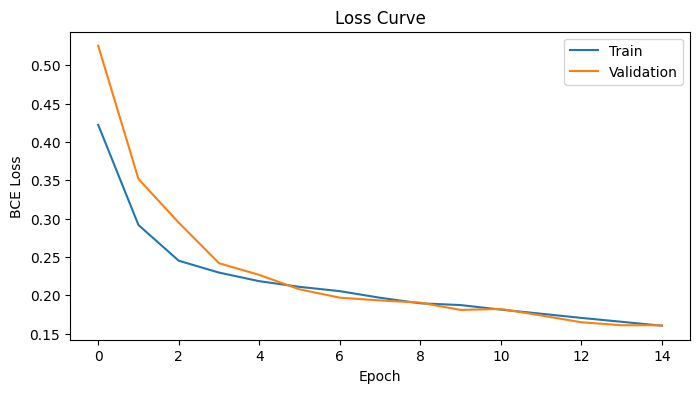

In [65]:
# Setup
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=CONFIG['LR'])
criterion = nn.BCEWithLogitsLoss()

# Train
best_model, t_hist, v_hist = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=CONFIG['EPOCHS']
)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(t_hist, label='Train')
plt.plot(v_hist, label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()
plt.show()

Calculating Final Test Metrics...
Average Test Dice Score: 0.8761


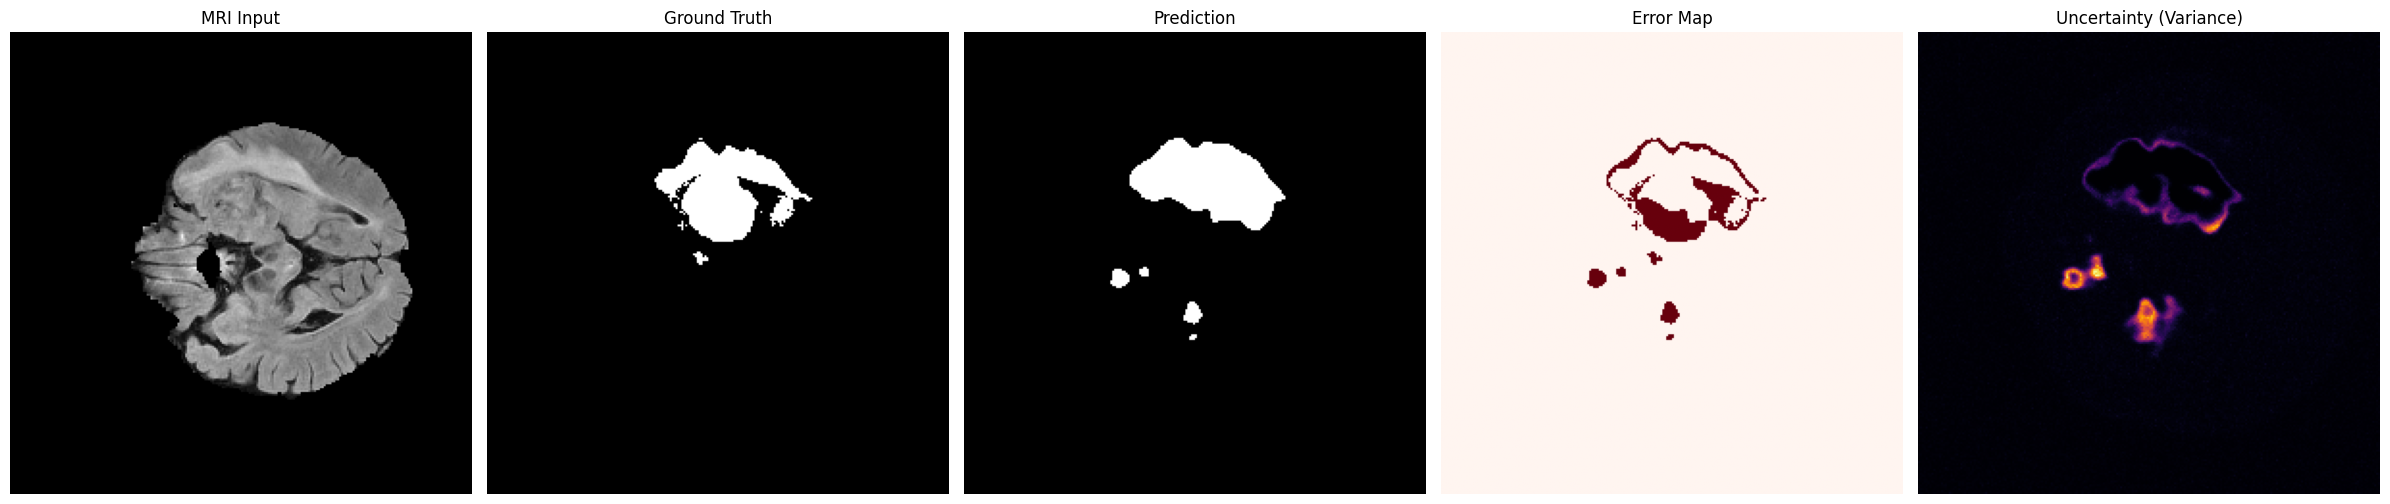

In [ ]:
# --- METRICS ---
def dice_coefficient(pred, target, smooth=1.0):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2. * inter + smooth) / (union + smooth)

def get_uncertainty(model, x, T=20):
    """
    Monte Carlo Dropout Inference.
    model.train() enables dropout.
    torch.no_grad() disables gradient calculation (fixes your error).
    """
    model.train()
    with torch.no_grad():
        preds = [torch.sigmoid(model(x)) for _ in range(T)]
    preds = torch.stack(preds)
    return preds.mean(dim=0), preds.var(dim=0)

# --- TEST SET EVALUATION ---
best_model.eval()
dice_scores = []

print("Calculating Final Test Metrics...")
with torch.no_grad():
    for img, mask in test_loader:
        img, mask = img.to(device), mask.to(device)
        out = best_model(img)
        dice_scores.append(dice_coefficient(out, mask).item())

print(f"Average Test Dice Score: {np.mean(dice_scores):.4f}")

# --- VISUALIZATION ---
# Get random test sample
if len(test_dataset) > 0:
    idx = np.random.randint(len(test_dataset))
    img, mask = test_dataset[idx]
    img_in = img.unsqueeze(0).to(device)

    mean_pred, unc_map = get_uncertainty(best_model, img_in, T=CONFIG['MC_DROPOUT_PASSES'])

    img_disp = img.squeeze().cpu().numpy()
    mask_disp = mask.squeeze().cpu().numpy()

    pred_disp = (mean_pred > 0.5).float().squeeze().cpu().numpy()
    unc_disp = unc_map.squeeze().cpu().numpy()

    # Error map: Difference between prediction and ground truth
    err_map = np.abs(pred_disp - mask_disp)

    # Plotting
    fig, ax = plt.subplots(1, 5, figsize=(24, 5))

    ax[0].imshow(img_disp, cmap='gray')
    ax[0].set_title('MRI Input')

    ax[1].imshow(mask_disp, cmap='gray')
    ax[1].set_title('Ground Truth')

    ax[2].imshow(pred_disp, cmap='gray')
    ax[2].set_title('Prediction')

    # Red colormap for errors
    ax[3].imshow(err_map, cmap='Reds')
    ax[3].set_title('Error Map')

    ax[4].imshow(unc_disp, cmap='inferno')
    ax[4].set_title('Uncertainty (Variance)')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Test dataset is empty.")

In [ ]:
model_save_path = 'unet_brain_mri_model.pth'

torch.save(best_model.state_dict(), model_save_path)

print(f"Model saved successfully to: {model_save_path}")

drive_save_path = '/content/drive/MyDrive/unet_brain_mri_model.pth'
torch.save(best_model.state_dict(), drive_save_path)
print(f"Backup saved to Drive: {drive_save_path}")

Model saved successfully to: unet_brain_mri_model.pth
Backup saved to Drive: /content/drive/MyDrive/unet_brain_mri_model.pth
